In [361]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt

from keras import applications
from efficientnet.tfkeras import EfficientNetB0
from keras import callbacks
from keras.models import Sequential
import cv2

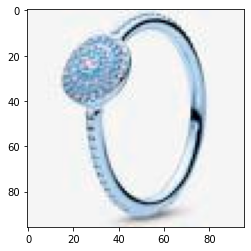

In [2]:
img = cv2.imread('data_small/train/150184CZ/150184CZ_00_OG.jpg')
plt.figure()
plt.imshow(img)

In [43]:
import json
def dict_from_json(path):
    # open the product catalog:
    a_file = open(path, "r")
    catalog = json.loads(a_file.read())
    a_file.close()
    return catalog
categories = dict_from_json('./catalog_by_category.json')

In [222]:
exclude = set(['model_images'])
filenames = []
d = 'data'
walk = os.walk(d, topdown=True)
for root, dirs, files in walk:
    dirs[:] = [d for d in dirs if d not in exclude]
    dirs[:] = [d for d in dirs if d in labelv]
    for file in files:
        if ".jpg" in file:
            filenames.append(os.path.join(root, file))

N = len(filenames)

In [226]:
folders = [os.path.join(d, o)[len(d)+1:] for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o)) and (os.path.join(d,o)[len(d)+1:] not in exclude) and (os.path.join(d,o)[len(d)+1:] in labelv)]

In [228]:
len(folders)

1709

In [213]:
labels = []
labelv = []
for folder in folders:
    for key, val in categories.items():
        if folder in val:
            #print(folder, val)
            labels.append([key] * len(os.listdir(d+'/'+folder)))
            labelv.append(folder)
                
flat_labels = [item for sublist in labels for item in sublist]
            
labels = np.array(flat_labels)


In [198]:
len(labels)

68360

In [357]:
data = np.zeros((len(labels), 96*96*3),dtype='uint8')

count = 0
for i, folder in enumerate(folders):
    for j, file in enumerate(os.listdir(d+'/'+folder)):
        file_ = d+'/'+folder+'/'+file
        data[count,:] = cv2.imread(file_).flatten()
        count += 1
        

In [358]:
data

array([[245, 245, 245, ..., 245, 245, 245],
       [255, 255, 255, ..., 248, 251, 255],
       [245, 245, 245, ..., 245, 245, 245],
       ...,
       [238, 242, 237, ..., 241, 241, 241],
       [241, 241, 241, ..., 241, 241, 241],
       [246, 244, 244, ..., 240, 237, 246]], dtype=uint8)

In [342]:
data.itemsize

1

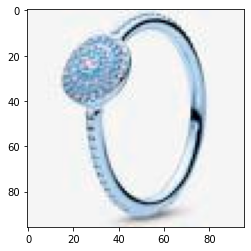

In [339]:
plt.imshow(data[0,:].reshape((96, 96, 3)))

In [337]:
# df = pd.DataFrame(data, labels)
# df.to_csv("foo.csv")

In [348]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,27638,27639,27640,27641,27642,27643,27644,27645,27646,27647
Rings,245,245,245,245,245,245,245,245,245,245,...,245,245,245,245,245,245,245,245,245,245
Rings,255,255,255,255,255,255,255,255,255,255,...,241,224,230,235,233,236,241,248,251,255
Rings,245,245,245,245,245,245,245,245,245,245,...,245,245,245,245,245,245,245,245,245,245
Rings,245,245,245,245,245,245,245,245,245,245,...,245,245,245,245,245,245,245,245,245,245
Rings,245,245,245,245,245,245,245,245,245,245,...,245,245,245,245,245,245,245,245,245,245


In [426]:
X = data
y = labels

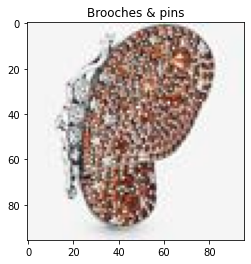

In [447]:
plt.imshow(X[25000,:].reshape((96,96,3)))
plt.title(y[25000]);

PCA

In [434]:
yp = y[::40] # every xth
Xp = X[::40]

classNames = sorted(set(yp))
classDict = dict(zip(classNames, range(5)))
N = len(yp)
C = len(classNames)
from scipy.linalg import svd
N

1709

In [451]:
# subtract the mean 
Xm = Xp - np.ones((N,1))*Xp.mean(0)

U,S,Vh = svd(Xm, full_matrices=False) 
# scipy.linalg.svd returns "Vh", which is the Hermitian (transpose)
# of the vector V. So, for us to obtain the correct V, we transpose:
V = Vh.T
# Project the centered data onto principal component space
Z = Xp @ V

C:\Users\andre\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


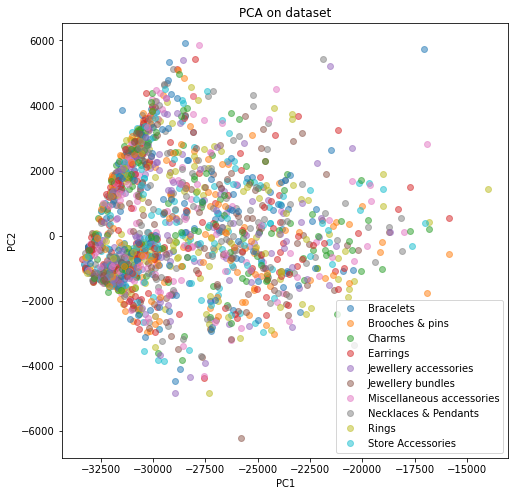

In [455]:
# Indices of the principal components to be plotted
i = 0
j = 1

# Plot PCA of the data
f = plt.figure(figsize=(8,8))
plt.title('PCA on dataset')
#Z = array(Z)
for c in classNames:
    # select indices belonging to class c:
    class_mask = np.where(yp == c)
    plt.plot(Z[class_mask, i], Z[class_mask, j], 'o', alpha=.5)
plt.legend(classNames)
plt.xlabel('PC{0}'.format(i+1))
plt.ylabel('PC{0}'.format(j+1));
plt.savefig('PCA.pdf');

## Model
Transfer

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(include_top=False, weights='imagenet')
# IMG_SIZE is determined by EfficientNet model choice (must be this)
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
IMG_SIZE = 224

In [365]:
from keras.layers import Dense
from keras.optimizers import Adam

efficient_net = EfficientNetB0(
    weights='imagenet',
    input_shape=(32,32,3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 1280)              4049564   
_________________________________________________________________
dense_3 (Dense)              (None, 120)               153720    
_________________________________________________________________
dense_4 (Dense)              (None, 120)               14520     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 121       
Total params: 4,217,925
Trainable params: 4,175,909
Non-trainable params: 42,016
_________________________________________________________________


In [366]:
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [367]:
history = model.fit(
    train_generator,
    epochs = 50,
    steps_per_epoch = 15,
    validation_data = val_generator,
    validation_steps = 7
)

NameError: name 'train_generator' is not defined